# DeepGANnel

A GAN made to generate synthetic ion channel data from previously recorded data, using a CNN model.

In [1]:
# Imports
import os, sys, socket
import random
import glob
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from statistics import mean
from copy import deepcopy
from tqdm import tqdm

import time
from datetime import datetime

from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, minmax_scale, RobustScaler, robust_scale
from IPython.display import clear_output

# Experimental - adding 1/f noise instead of gaussian noise

#from colorednoise import powerlaw_psd_gaussian

In [2]:
#Datasource
DATAFOLDER='Sam_CAP_IOP'
# Constants
# Have only verified 50, 100, 250
BATCH_SIZE = 100
# Have only verified 512, 1024, 2048, 4096
WINDOW_SIZE = 4096
SI= None # will be set in a function
#Add a little noise to facilitate CNN "throughout"
NOISE_AMP = 1e-6
MAX_C = None #To be set in the preprocessing phase
#0 is accept records that are all one state; 0.5 is,accept only records with more than 50% of each state
#Not sure what happens with 0.5 or more so recommend range of 0 to 0.25
#Note if too high preprocess data will loop indefinitely at some stage.
THRESHOLD = 0.2
"""In this case (below) dont accept it if over x (eg 0.5) fraction open. """
OTHRESHOLD = 0.9 
"""When working really well no cropping needed. Often 100 sensible"""
CROP = 100
"""clip the loss function gradients?"""
CLIP = False
"""clip the idealised data to 1 channel"""
TFCLIP = True
"""Filter the output?"""
FILTER = False
#Try a critic approach rather than strictly discriminator
Wasserstein=False
ADAMO=True
"""decimation value of 1 means no decimation. Take every point"""
DECIMATE = 1
"""As error checking we need to check no major deviations from the typival closed state when training"""
GMEANS = []

scaler = RobustScaler(quantile_range=(0.1, 99.9))
"""To stop us writing unscaled records with a different inverse transform each time, we mess around.
When writing starts the FIRST TIME (No File exists) we grab the latest scaler... hope it is sensible one and 
then lock it down."""
WRITESCALER = scaler
SCALERSET = False
scripts = glob.glob('*.ipynb')
myPC=socket.gethostname()
with open ("runs.txt","a") as runs:
    runs.write(f"This PC is {myPC}\nDate is {datetime.now()}\nTF= {tf.__version__}\n")
    runs.write(f'Data is in folder {DATAFOLDER}\n')
    runs.write(f"Script name: {scripts}\n")
    runs.write(f"Wasserstein was used? {Wasserstein}\n")
    runs.write(f'Adam used (SGD if false) {ADAMO}')
    runs.write(f"BATCH_SIZE = {BATCH_SIZE}, WINDOW_SIZE = {WINDOW_SIZE}, NOISE_AMP = {NOISE_AMP}, THRESHOLD = {THRESHOLD}\n\n")

print("Dome")

Dome


In [3]:
THRESHOLD

0.1

A Butterworth filter can help clean-up the output which tends to retain a little HF noise otherwise

In [4]:
# Define the Butterworth filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
print (tf.__version__)
print(tf.config.list_physical_devices())
print(tf.test.is_built_with_cuda())

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [7]:
def plothist(dome):
    plt.subplot(1,2,1)
    n, bins, patches =plt.hist(dome[:,0],bins=100)
    plt.subplot(1,2,2)
    n, bins, patches =plt.hist(dome[:,1],bins=100)
    #plt.xlim([-0.6,0.4])
    #plt.xlim([-0.6,0.4])
    data = {'1cur': dome[:,0],
                    '2chan': dome[:,1]}
    df = pd.DataFrame (data, columns = ['1cur','2chan'])
    #print (df)
    """df.to_csv(f'{WINDOW_SIZE}PYRraw.csv', index =False, header=False)"""

In [8]:
def preprocess_data() -> ():   
    """ 
    Preprocessing data into one large numpy array - along with a list of
    marker start indexes for randomly sampling batches.
    
    If an index < marker AND index + WINDOW_SIZE > marker, they'll be a change
    of file in the window, therefore it's invalid.
    """
    global SI
    cwd = os.getcwd()
    """alternatives
    files = os.listdir(f'{cwd}/synth_data')
    files = glob.glob('synth_data/*.csv')
    NOW PARQUET"""
    files = glob.glob(f'{DATAFOLDER}/*.parquet')
    print(files)
    output_data = np.array([[0,0]])
    MAX_C = 0
    for filename in files:
        print(f'Processing {filename}')
        pq = pd.read_parquet(filename)
        data=pq.loc[:,["Noisy Current", "Channels"]].to_numpy()[::DECIMATE]
        """Scale each file and then hope the last scaler object is representative for the unecale later"""
        """scaler = RobustScaler(quantile_range=(0.1, 99.9))
        scaler = scaler.fit(np.asarray(data[:,0]).reshape(-1,1))
        x = scaler.transform(np.asarray(data[:,0]).reshape(-1,1))
        data[:,0] = x.reshape(-1)"""
        
        if pq.loc[:,"Channels"].max() > MAX_C:
            MAX_C = pq.loc[:,"Channels"].max()
        """We dropped any time column there may have been"""
        """But keep the sample interval?"""
        try:
            SI = round((pq.loc[100,"Time"]-pq.loc[90,"Time"])/10.0,6)
            print(f"Sample interval read as {SI:.3f}")
        except:
            # Default SI, probably overwritten later
            SI = 1e-4
            print("No time column so assuming sample interval is: ", SI, "s")
        output_data = np.concatenate((output_data, data))
        print("Fulldata shape is", output_data.shape)

    return output_data, scaler
    
preprocessed_data, scaler = preprocess_data()

['Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_10.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_11.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_12.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_13.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_14.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_15.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_16.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_17.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_18.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_19.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_20.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_21.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_22.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_23.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_24.parquet', 'Sam_CAP_IOP\\cell_1 hek_bkca_0000_stmball_-60.0_25.parquet', 'Sam_CA

In [9]:
print(SI)

0.004


print(SI)

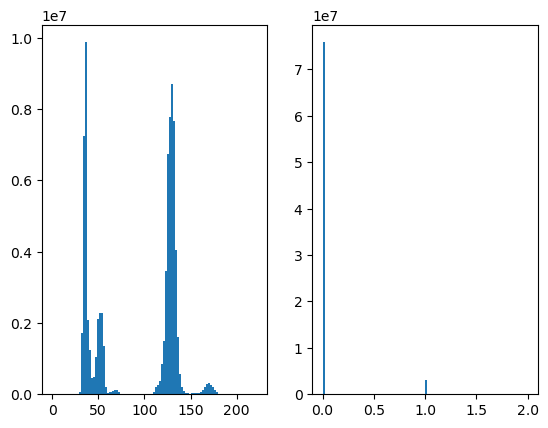

In [10]:
plothist(preprocessed_data)

In [11]:
"""Minmax scale the current on the whole bloody lot"""
"""preprocessed_data[:,0]=minmax_scale(preprocessed_data[:, 0])"""
"""scaler=RobustScaler().fit(np.asarray(preprocessed_data[:,0]).reshape(-1,1))"""
"""scaler = MinMaxScaler()
scaler = RobustScaler(quantile_range=(0.1, 99.9))
scaler = scaler.fit(np.asarray(preprocessed_data[:,0]).reshape(-1,1))
x = scaler.transform(np.asarray(preprocessed_data[:,0]).reshape(-1,1))"""
"""rather late spotted that doing it with the below leaves no chance to inverse it!
so now creating a scale option that can be used at the end to unscale it back to meet the original"""
"""preprocessed_data[:,0]=robust_scale(preprocessed_data[:,0])/2.0"""
"""preprocessed_data[:,0] = x.reshape(-1)"""

print (np.amin(preprocessed_data[:,1]),np.amax(preprocessed_data[:,1]))
print (np.amin(preprocessed_data[:,0]),np.amax(preprocessed_data[:,0]))
print(preprocessed_data.shape)
print(type(preprocessed_data))


0.0 2.0
0.0 221.92381
(79000001, 2)
<class 'numpy.ndarray'>


## Step 2: Building Models

Here we are using two CNN models for the generator and discriminator - we also need to build the loss functions and optimizers for the two models.

"df.to_csv(f'{WINDOW_SIZE}PYRraw.csv', index =False, header=False)"

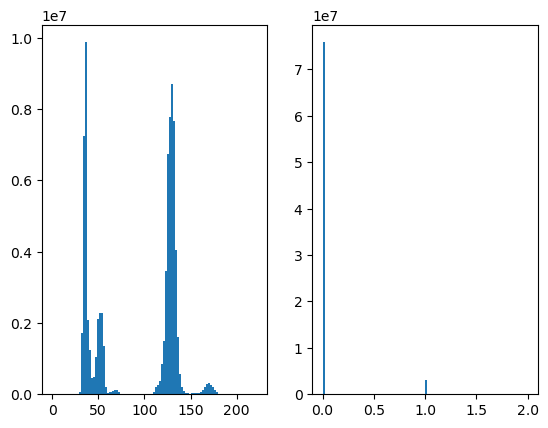

In [12]:
plt.subplot(1,2,1)
n, bins, patches =plt.hist(preprocessed_data[:,0],bins=100)
plt.subplot(1,2,2)
n, bins, patches =plt.hist(preprocessed_data[:,1],bins=100)
#plt.xlim([-0.6,0.4])
#plt.xlim([-0.6,0.4])
data = {'1cur': preprocessed_data[:,0],
                '2chan': preprocessed_data[:,1]}
df = pd.DataFrame (data, columns = ['1cur','2chan'])
#print (df)
"""df.to_csv(f'{WINDOW_SIZE}PYRraw.csv', index =False, header=False)"""

## Step 2: Building Models

Here we are using two CNN models for the generator and discriminator - we also need to build the loss functions and optimizers for the two models.

In [13]:
def make_generator_model() -> tf.keras.Model:
    """
        Makes the generator model.
    """
    dropout=0
    model = tf.keras.Sequential(name="Generator")

    model.add(layers.Dense(2*16*64, use_bias=False, input_shape=(WINDOW_SIZE,), dtype='float32'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2, 16, 64)))
    assert model.output_shape == (None, 2, 16, 64) # Note: None is the batch size

    size = 16
    s=1
    while size < WINDOW_SIZE/2:

        num_filters = 128 if size < 512 else 256

        model.add(layers.Conv2DTranspose(num_filters, (2, 5), strides=(1, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        if dropout>0:
            model.add(layers.Dropout(dropout))
        size *= 2
    #EXTRALAYERSE
    """
    model.add(layers.Conv2DTranspose(64, (2, 5), strides=(1, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    if dropout>0:
           model.add(layers.Dropout(dropout))

    model.add(layers.Conv2DTranspose(64, (2, 5), strides=(1, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    if dropout>0:
           model.add(layers.Dropout(dropout))
    #EXTRALAYERS END
    """
    model.add(layers.Conv2DTranspose(1, (2, 5), strides=(1, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    if dropout>0:
           model.add(layers.Dropout(dropout))
    """
    # Add a cropping layer to clip the output shape and keep the middle
    crop_width = (model.output_shape[2]  - WINDOW_SIZE) // 2
    cu_win_length = model.output_shape[2]
    model.add(layers.Cropping2D(cropping=((0, 0), (crop_width, cu_win_length - WINDOW_SIZE - crop_width))))
    """

    assert model.output_shape == (None, 2, WINDOW_SIZE, 1)

    return model

def make_discriminator_model() -> tf.keras.Model:
    """
        Makes the discriminator model.
    """
    dropout=0.1
    model = tf.keras.Sequential(name="Discriminator")

    model.add(layers.Conv2D(32, (2, 100), strides=(1, 2), padding='same', input_shape=[2, WINDOW_SIZE, 1],dtype='float32'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(64, (2, 50), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(64, (2, 25), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(64, (2, 5), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(128, (2, 5), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(256, (2, 5), strides=(1, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(dropout))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
"""Real all real output SHOULD be all ones -> True""" 
"""Conversely all fake-output SHOULD be zeros -> False"""
def discriminator_loss(real_output, fake_output) -> float:        
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   
    if Wasserstein==True:
        fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        total_loss =real_loss - fake_loss
    else:
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    
    return total_loss

"""IF generator is perfect the fake output would all be ones... (look like real)"""    
def generator_loss(fake_output) -> float:
    return cross_entropy(tf.ones_like(fake_output), fake_output)

if ADAMO==True:
    # Optimizers
    generator_optimizer = tf.keras.optimizers.Adam(1e-3, amsgrad=True)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, amsgrad=True)
else:
    #Otherwise just use SGD
    generator_optimizer = tf.keras.optimizers.SGD(1e-6)
    discriminator_optimizer = tf.keras.optimizers.SGD(1e-6)


# Now build everything.
generator = make_generator_model()
discriminator = make_discriminator_model()    
    
#it appears that the change_lrs() is currently impotent.
def change_lrs(old_gen_lr: float, 
               old_disc_lr: float, 
               gen_loss_history: list, 
               disc_loss_history: list,
               reduction_factor: int = 2, 
               threshold_factor: int = 5, 
               history_length: int = 10):
    # Changing the learning rates dynamically based on the last 100 epochs 
    # If either model has a loss 5x the other over hte last 10 training steps,
    # multiply the "bad" model's learning rate by a factor (default 2) and
    # divide the "good" model's learning rate by the same amount
    
    # Also allow switching from "automatic" to "manual" using a text file "lr.txt"
    
    with open("lr.txt", "r+") as my_file:
        data = my_file.read()

        split = data.split('\n')
        automatic = True if "True" in split[0] else False
        new_gen_lr = 0
        new_disc_lr = 0

        if automatic:
            # Automatic method ONLY LIKELY TO WORK IF POSITIVE LOSSES ALL AROUND
            if len(gen_loss_history) == 0:
                # If no history, keep it how it is
                return old_gen_lr, old_disc_lr
            
            elif history_length > len(gen_loss_history):
                mean_recent_gen = mean(gen_loss_history[-history_length:])
                mean_recent_disc = mean(disc_loss_history[-history_length:])
            else:
                mean_recent_gen = mean(gen_loss_history)
                mean_recent_disc = mean(disc_loss_history)
                
            if mean_recent_gen >= threshold_factor * mean_recent_disc:
                new_gen_lr = old_gen_lr / 5
                new_disc_lr = old_disc_lr * 5
            elif mean_recent_disc >= threshold_factor * mean_recent_gen:
                new_disc_lr = old_disc_lr / 5
                new_gen_lr = old_gen_lr * 5
                
            else:
                new_disc_lr = old_disc_lr
                new_gen_lr = old_gen_lr
                    
        else:
            # Manual method
                
            parse_lr_from_file = lambda string: float(string.split(":")[1])
            new_gen_lr = parse_lr_from_file(split[1])
            new_disc_lr = parse_lr_from_file(split[2])
            
        tf.keras.backend.set_value(generator_optimizer.learning_rate,new_gen_lr)
        tf.keras.backend.set_value(discriminator_optimizer.learning_rate,new_disc_lr)
        # Save the new data
        new_data = f"AUTOMATIC : {automatic}\nGENERATOR_LEARNING_RATE : {new_gen_lr}\nDISCRIMINATOR_LEARNING_RATE : {new_disc_lr}"
        my_file.seek(0)
        my_file.truncate(0)
        my_file.write(new_data)

    return new_gen_lr, new_disc_lr
    


In [14]:
16384/4096

4.0

In [156]:
THRESHOLD = 0.2

In [16]:
# Checkpoints and image generation
checkpoint_dir = "training_checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

def getREALepoch() -> int:
    """
    Save the current image to the working directory of the program.
    """
    currentImages = glob.glob("images/*.png")
   
    numList = [0]
    for img in currentImages:
        i = os.path.splitext(img)[0]
        try:
            num = re.findall('[0-9]+$', i)[0]
            numList.append(int(num))
        except IndexError:
            pass
    numList = sorted(numList)
    return numList[-1]+1

def unscale_images(data: np.array, write=False: boolean):
    global scaler
    if SCALERSET and write:
        scaler = WRITESCALER
    #split the current and channels
    tcurrent = tf.reshape(data[:,0,:,:],(-1,1))
    scurrent = scaler.inverse_transform(tcurrent)
    tchannels = tf.reshape(data[:,1,:,:],(-1,1))
    return [scurrent,tcurrent]
    
def make_images(model, epoch, gen_loss_list, disc_loss_list,inlineplot=True, plot=True):
    global WRITESCALER
    global SCALERSET
    ymax=2
    me=random.randrange(BATCH_SIZE)
    noise = tf.random.normal([BATCH_SIZE, WINDOW_SIZE])
    generated_output = np.asarray(model(noise, training = False))
    if ROUND:
        # Create a mask tensor of the same shape as your original tensor, 
        # with 1s at the positions you want to round and 0s elsewhere
        mask = tf.concat([tf.ones_like(generated_output[:, :1, :, :]), 
                          tf.zeros_like(generated_output[:, 1:2, :, :]), 
                          tf.ones_like(generated_output[:, 2:, :, :])], axis=1)
    
        # Round the entire tensor
        rounded_output = tf.round(generated_output)
    
        # Use the mask to select values from the original tensor and the rounded tensor
        generated_output = mask * generated_output + (1 - mask) * rounded_output

    # Cast the entire tensor to tf.float64 data type
    # Later -> generated_output = tf.dtypes.cast(generated_output, tf.float64)

    """
    print(generated_output.shape)
    print(type(generated_output)) ??
    Why the next lines?? A bug fix of somesort
    """
    #generated_output=np.copy(generated_output)
    #rawidl=generated_output[me, 1, :, 0].copy()
    """print(generated_output.flags)"""
    twostate=False
    thresh=0.6 #unused?
    #generated_output[:, 1, :, 0]=np.clip(np.round(generated_output[:, 1, :, 0]),0,MAX_C)
    if TFCLIP:
        #Clip the channels to 0 or 1.
            """expected shape=(None, 2, 2048, 1), found shape=(100, 2, 1, 2)"""
            clipped_values = tf.clip_by_value(generated_output[:, 1, :], 0, 1)
            # Combine the clipped values with the unclipped values from the first dimension (index 0)
            generated_output = tf.stack([generated_output[:, 0, :], clipped_values], axis=1)
            

    # Cast the entire tensor to tf.float64 data type
    generated_output = tf.dtypes.cast(generated_output, tf.float64)
    
    # Give it a little filtering Define the frequency and order of the filter
    cutoff = 10.0 * 10**3  # 10kHz
    fs = 1.0 / (SI*1e-3)  # sampling rate often in ms, rather than seconds irritatingly
    order = 6 # sensible number
  
    inlineplot = not plot
    ymin = np.amin(generated_output[:, :, :, :])
    ymin=-1
    NEARREADY=True
    if inlineplot==True:
        %matplotlib inline
        
        ax1_length = generated_output.shape[2]
        plt.figure(figsize=[10,4])
        plt.plot(range(ax1_length), generated_output[me, 1, :, :],'r-', label="Channels")
        
        if NEARREADY:
            plt.plot(range(ax1_length), generated_output[me, 0, :, :], 'b-', label="Current")
            ymin=-0.3
            ymax=1.3
        else:
            plt.scatter(range(ax1_length), generated_output[me, 0, :, :], s=1, label="Current")
            # Apply the filter
            f_generated_output = butter_lowpass_filter(generated_output[me, 0, :, 0], cutoff, fs, order)            
            ymax = np.amax(generated_output[:, :, :, :])
            plt.plot(range(ax1_length), f_generated_output, c='k', label="filtered")
        plt.ylim([ymin, ymax] )     
    
        #plt.scatter(range(len(rawidl)), rawidl, color ='g', s=1, label="Raw Channels")

        plt.legend()
        plt.show()
    
    if plot==True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
        ax1_length = generated_output.shape[2]
        if NEARREADY:
            ax1.plot(range(ax1_length), generated_output[me, 0, :, :], c='k', label="Current")
        else:
            ax1.plot(range(ax1_length), f_generated_output, label="filtered")
            ax1.scatter(range(ax1_length), generated_output[me, 0, :, :], s=1, c='k', label="Current")          
        ax1.plot(range(ax1_length), generated_output[me, 1, :, :],'r-', label="Channels")
        #ax1.scatter(range(len(rawidl)), rawidl, color ='g', s=1, label="Raw Channels")
        ax1.set_ylim([ymin,ymax])
        ax1.legend()

        ax2_length = len(gen_loss_list)
        ax2.plot(range(ax2_length), [loss+1 for loss in disc_loss_list], label="Discriminator")
        ax2.plot(range(ax2_length), [loss+1 for loss in gen_loss_list], label="Generator")
        ax2.set_yscale("log")
        #ax2.set_ylim(ymax = 10)
        ax2.legend()

        image_batch = make_batch(BATCH_SIZE, WINDOW_SIZE, preprocessed_data)
        me=random.randrange(len(image_batch[:,0,0,0]))
        ax3.plot(image_batch[me,0,:,:])
        ax3.plot(image_batch[me,1,:,:])
        ax3.set_ylim([ymin,ymax])
        from datetime import datetime

        # Get the current time
        now = datetime.now()

        # Convert the current time to a string
        current_time = now.strftime("%H:%M:%S")    
        plt.title(f"Current Time: {current_time}")

        plt.savefig(f"images/epoch_{getREALepoch()}.png")
        plt.close()
    with open("save.txt", "r") as my_file:
        data = my_file.read()
        split = data.split('\n')
        saveme = True if "True" in split[0] else False
    #print (saveme)
    if saveme:
        print("WRITING TO FILE!!")
        print("READING ANY EXISTING DATA FILE!!")
        try:
            rump = pd.read_csv(f'{WINDOW_SIZE}gen_data{DATAFOLDER}.csv')
            read=True
        except:
            print("No existing file")
            maxT = 0
            read = False
            WRITESCALER = scaler
            SCALERSET = True
        header = True
        if read:
            header = False
            rump = rump.apply(pd.to_numeric, errors='coerce')
            rump["Time"].max()
            maxT = rump["Time"].max()
        scaled = unscale_images(generated_output, write=True)
        print("Now actually writing")
        ender=1+CROP
        current = scaled[0]
        current = np.asarray(current).reshape(-1,1) #The current
        channels = scaled[1]
        channels = tf.reshape(channels,(-1,1)) #The channels
       
        if FILTER:
            current = butter_lowpass_filter(current[CROP:-ender], cutoff, fs, order)
        current =  current[CROP:-ender].reshape(-1)
        channels =  np.round(channels[CROP:-ender]).reshape(-1)
       
        #NOT SURE THE NUMPY AND RESHAPING IS NECESSARY BUT WHY NOT
        data = {'Noisy Current': current ,
            'Channels': channels }
        df = pd.DataFrame (data)
        df["Time"] = np.round((np.linspace(0,SI*len(df),len(df)) + maxT)/SI)*SI
        maxT = df["Time"].max()
        """Presumably first shot, so write the header!"""
        df.to_csv(f'{WINDOW_SIZE}gen_data{DATAFOLDER}.csv', mode='a', index = False, header=header)
    return generated_output[:,0:2,:]

In [157]:
def check_window(channel_record: np.ndarray) -> bool:
    """just for debugging"""
    global openstrip
    """ Returns True if there is enough activity in the window AND LOOKS RIGHT """
    
    """return True if (1 in channel_record[:,1:]) and (0 in channel_record[:,1:]) else False"""
    """toughen this up, want more than one single event :-)"""
    threshold = THRESHOLD
    maxOpen = 1 - OTHRESHOLD
    total=len(channel_record[:,1])
    openstrip = channel_record
    opens=len(channel_record[channel_record[:,1]==1,1])
    val=True if ((opens/total >threshold) and (opens/total <(1-threshold))) else False
    """val=True if ((opens/total >= threshold) and (opens/total < maxOpen)) else False"""
    if val:
        """Don't even try to simulate multistate time points with this version"""
        val = (max(channel_record[:,1]) == 1)  
    return val
    

FIRST
SECOND


True

In [124]:
def scale(window):
    global scaler
    current  = window[:, 0]
    channels = window[:, 1]
    
    scaler = scaler.fit(current.reshape(-1,1))
    x = scaler.transform(current.reshape(-1,1))
    current = x.reshape(-1)

    return  np.stack((current, channels), axis=1)

def check_window_again(channel_record):
    global GMEANS
    val = False
    """Is the baseline sensible?"""
    strip = channel_record[channel_record[:,1]==0,0]
    if len(strip) < 1:
        print("LENGTH ERROR")
        plt.plot(channel_record[:,0])
        plt.plot(channel_record[:,1])
        plt.show()
        return HANG
    wmean = np.mean(strip)
    GMEANS.append(wmean)
    if len(GMEANS) >2:
        gmean = np.mean(GMEANS)
        gsd = np.std(GMEANS)
        """tf.print(f"Window mean {wmean:.2f}, Global mean {gmean:.2f}, GSD {gsd:.2f}")"""
        val = wmean > (gmean - 3 * gsd) and wmean < (gmean + 3 * gsd)
        if len(GMEANS) > 1000:
            GMEANS = GMEANS[-1000:]
    return val

def make_window(data: np.ndarray) -> np.ndarray:
    """
        Grabs one window from the dataset, checking to see if it is valid or 
        not first
    """
    invalid1 = True
    invalid2 = True
    loops=0
    while invalid1 or invalid2:
        """Choose a bit"""
        index = random.randrange(len(data) - WINDOW_SIZE)
        current  = data[index:index+WINDOW_SIZE, 0]+np.random.normal(0,NOISE_AMP,WINDOW_SIZE)
        channels = data[index:index+WINDOW_SIZE, 1]
        window = np.stack((current, channels), axis=1)
        
        """Check if window will be valid, need to constantly reset to True if any fail or the 
        next loop ends up incorrectly calling valid"""
        if check_window(window):
            invalid1 = False
        else:
            invalid1 = True
            invalid2 = True
        if not invalid1:    
            """zcale it as needed"""
            window = scale(window)
            """check the baseline"""
            if check_window_again(window):
                invalid2 = False
            else:
                invalid2 = True
                invalid1 = True
        
        loops+=1
        if loops>100000:
            #Eventually just give up.
            print('HELP looks like threshold to strict, am about to crash!',end="\r")
            return -1
 
    return window

def make_batch(batch_size: int, window_size: int, data: np.ndarray) -> np.ndarray:
    """
        Formats one of the files into the required size for the model.
        Since we have already preprocessed the data, we know this data is 
        scaled, and contains events. All we need to do is shape.
    """
    data = [make_window(data) for _ in range(batch_size)]
    # Force data to be correct shape.
    reshaped = np.expand_dims(np.swapaxes(np.stack(data, axis=0), 1, 2), axis=-1)
    return reshaped


In [160]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
@tf.function
def train_step(real_data: np.ndarray, GenTrain: bool=True, DiscTrain: bool=True) -> (float, float):    
    """ 
    One training step - generates noise, generates a output using the 
    generator model, then tests the discriminator on both the fake output and
    real data.
    
    """  
    # Generate latent vector for the generator. This should be 50% around 1 and 50% around zero?
    """if random.choice([True,False]):
        noise = tf.random.normal([BATCH_SIZE, WINDOW_SIZE], mean=1.0)
    else:
        noise = tf.random.normal([BATCH_SIZE, WINDOW_SIZE], mean=0)
    """
    # Generate time values
    t = np.linspace(0, 1, WINDOW_SIZE, endpoint=False)
    
    def penalize_similarity(images, alpha=1):
        """not sure these are correct. Bigger distance should be good..."""
        DTW = False
        loss=0
        #the euclidean bit fails!?
        # Flatten the images NO GO IN A TF FUNCTION OF COURSE!!
       
        if DTW:
            # Calculate pairwise DTW distances  DONT WORK!!
            n = tf.shape(images)[0]
            loss = 0
            for i in range(n-2):
                x = images[i].numpy().reshape(-1)
                y = images[i + 1].numpy().reshape(-1)
                distance, _ = fastdtw(x,y, dist=euclidean)
                loss += distance
        elif alpha > 0:
            # Calculate pairwise distances
            """Surely easiest thing is just workout the MAE accross the batch"""
            absolute_difference = tf.abs(images[10,:,:] - images[9,:,:])
            # Calculate the mean absolute error
            mae = tf.reduce_mean(absolute_difference)
            """
            How about a different pair each time:
            me=random.randrange(BATCH_SIZE-2)
            me and me-1
            Or how about making this over the whole batch
            
            """
            #Normalise for the maximum possible error, since BIG MAE is whast we want
            mmae = WINDOW_SIZE * 4 #since two layers scaled to -1 .> +1
            loss = mmae / mae
        
        """Remember a big distance is good"""
        return ( alpha * loss)

 
    # Create a function to generate a single square wave
    def generate_square_wave():
        length = np.random.randint(np.floor(0.15 * WINDOW_SIZE), np.floor(0.85 * WINDOW_SIZE))
        start_point = np.random.randint(0, WINDOW_SIZE - length)
        end_point = start_point + length
        return tf.where((t >= start_point) & (t < end_point), 1.0, 0.0)
    if False:
        # Generate the batch of square waves
        noise = tf.stack([generate_square_wave() for _ in range(BATCH_SIZE)])
    else:
        # Generate latent vector for the generator I'm wondering why not shape [BATCH_SIZE, WINDOW_SIZE, 2] ??
        noise = tf.random.normal([BATCH_SIZE, WINDOW_SIZE])
    
    # Use generator to create fake output, and then test the discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_output = generator(noise, training = GenTrain)
        ROUND =False
        """This was 'helped' with ChatGPT and destroyed training!!
        Surely just rounded_idl = tf.round(generated_output[:,:,1])
        generated_output = tf.concat(?)(gnerated_output[:,:,0], rounded_idl)  ??
        ACTYUALLY USING CLIPPING NOW INSTEAD
        """
        if ROUND:
            # Create a mask tensor of the same shape as your original tensor, 
            # with 1s at the positions you want to round and 0s elsewhere
            mask = tf.concat([tf.ones_like(generated_output[:, :1, :, :]), 
                              tf.zeros_like(generated_output[:, 1:2, :, :]), 
                              tf.ones_like(generated_output[:, 2:, :, :])], axis=1)
        
            # Round the entire tensor
            rounded_output = tf.round(generated_output)
        
            # Use the mask to select values from the original tensor and the rounded tensor
            generated_output = mask * generated_output + (1 - mask) * rounded_output
        
        if TFCLIP:
            """expected shape=(None, 2, 2048, 1), found shape=(100, 2, 1, 2)"""
            clipped_values = tf.clip_by_value(generated_output[:, 1, :, 0], 0, 1)
            # Combine the clipped values with the unclipped values from the first dimension (index 0)
            generated_output = tf.stack([generated_output[:, 0, :, 0], clipped_values], axis=1)
            

        # Cast the entire tensor to tf.float64 data type
        generated_output = tf.dtypes.cast(generated_output, tf.float64)

        real_output = discriminator(real_data, training = DiscTrain)
        fake_output = discriminator(generated_output, training = DiscTrain)

        #I propose here to get the difference between the generated images and use that as a contribution to loss

        gen_loss = generator_loss(fake_output)
        # But also punish batches with very similar images
        similarity_loss = penalize_similarity(generated_output)
        total_gen_loss = gen_loss + tf.cast(similarity_loss, tf.float32)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply these gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    if CLIP:
        # Clip the discriminator's weight
        for var in discriminator.trainable_variables:
            var.assign(tf.clip_by_value(var, -0.001, 0.001))
    
    return disc_loss, gen_loss

def train(dataset: np.ndarray, epochs: int, start_epoch = 0) -> None:
    """
        Function for training the model using the training steps as described
        above. Includes plots for monitoring progress.
    """   
    gen_loss_list, disc_loss_list = [], []
    print("Starting Training")
    for epoch in range(epochs):
        # Time it for the console
        start = time.time()
        GenTrain=False
        DiscTrain=True
        # The important part!
        for _ in tqdm(range(BATCH_SIZE)):
            GenTrain=True if GenTrain==False else False
            DiscTrain=True if GenTrain==False else False
            """
            DiscTrain = True
            GenTrain = True"""
            
            image_batch = make_batch(BATCH_SIZE, WINDOW_SIZE, dataset)
            disc_loss, gen_loss = train_step(image_batch, GenTrain=GenTrain, DiscTrain=DiscTrain)
        
        # Dynamic control of learning rates
        gen_lr = tf.keras.backend.get_value(generator_optimizer.learning_rate)
        disc_lr = tf.keras.backend.get_value(discriminator_optimizer.learning_rate)
        
        new_gen_lr, new_disc_lr = change_lrs(gen_lr, disc_lr, gen_loss_list, disc_loss_list)
        # Console outputs        
        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())
        clear_output(wait=True)
        print(f"Time for epoch {epoch + start_epoch} is {time.time() - start:.3f}.")
        print(f"Discriminator loss: {mean(disc_loss_list):.3e}.")
        print(f"Generator loss: {mean(gen_loss_list):.3f}.")
        print(f"DLR : {tf.keras.backend.get_value(discriminator_optimizer.learning_rate):.3e}.")
        print(f"GLR: {tf.keras.backend.get_value(generator_optimizer.learning_rate):.3e}.")
        make_images(generator, 0, gen_loss_list=[], disc_loss_list=[], inlineplot=True, plot=False)
        if epoch%10 == 0:
            checkpoint.save(file_prefix = 'checkpoints/checkpoint_')
            make_images(generator, epoch + start_epoch, gen_loss_list, disc_loss_list, plot=True)
        
 

(100, 2, 4096, 1)


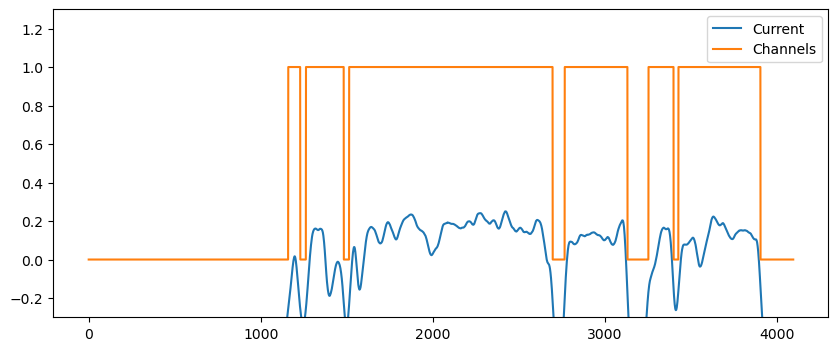

In [161]:
# Test plot
plt.figure(figsize=[10,4])
image_batch = make_batch(BATCH_SIZE, WINDOW_SIZE, preprocessed_data)
print(image_batch.shape)
plt.plot(image_batch[0,0,:,:],label="Current")
plt.plot(image_batch[0,1,:,:],label="Channels")
plt.ylim(-0.3,1.3)
plt.legend()
plt.show()

In [140]:
max(openstrip[:,1]) 

1.0

Time for epoch 70 is 59.473.
Discriminator loss: 8.543e-03.
Generator loss: 14.735.
DLR : 1.000e-04.
GLR: 2.000e-06.


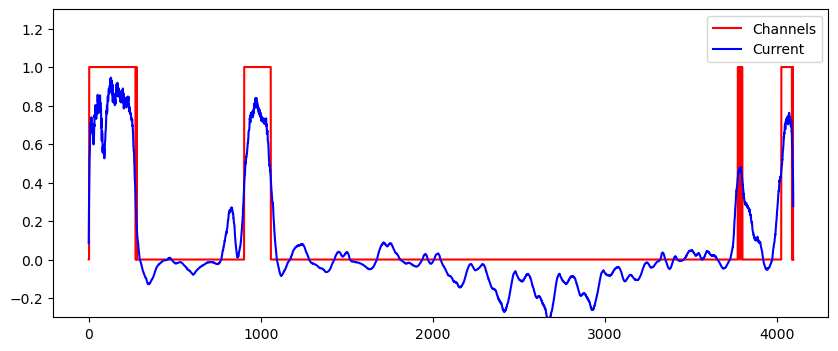

 53%|██████████████████████████████████████████▉                                      | 53/100 [00:30<00:27,  1.71it/s]

In [ ]:
#Each "epoch", of course a batch of BATCH records. train(preprocessed_data, number of epochs,  starting epoch)
train(preprocessed_data, 10000, 0 )

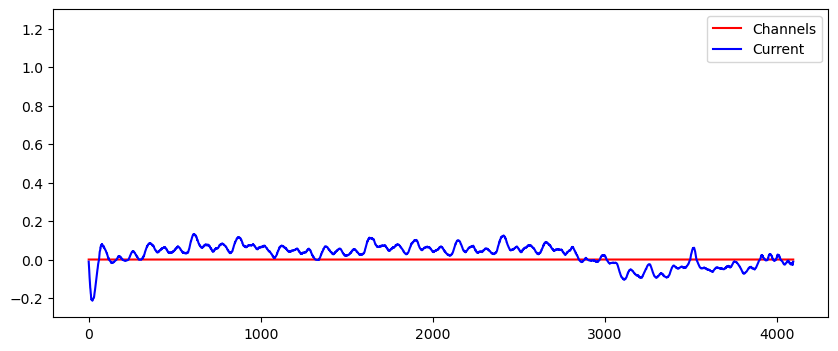

In [150]:
checkpoint.restore('checkpoints/checkpoint_-77').assert_existing_objects_matched()
make_images(generator, 0, gen_loss_list=[], disc_loss_list=[],plot=False)
tf.keras.backend.set_value(generator_optimizer.learning_rate,1e-8)
tf.keras.backend.set_value(discriminator_optimizer.learning_rate,1e-8)
gen_loss_list=[]
disc_loss_list=[]

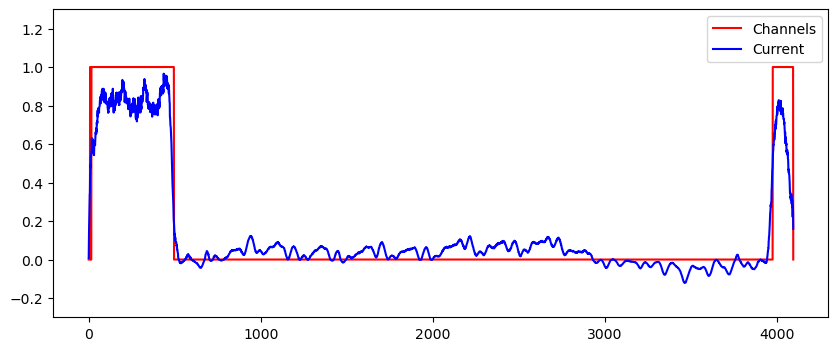

In [155]:
checkpoint.restore('checkpoints/checkpoint_-66').assert_existing_objects_matched()
make_images(generator, 0, gen_loss_list=[], disc_loss_list=[],plot=False)
tf.keras.backend.set_value(generator_optimizer.learning_rate,1e-8)
tf.keras.backend.set_value(discriminator_optimizer.learning_rate,1e-8)
gen_loss_list=[]
disc_loss_list=[]

In [154]:
print(gen_loss_list)

[]


In [ ]:
THRESHOLD

In [ ]:
gen_loss_list=[]
disc_loss_list=[]

(2048, 1)
(2048,)


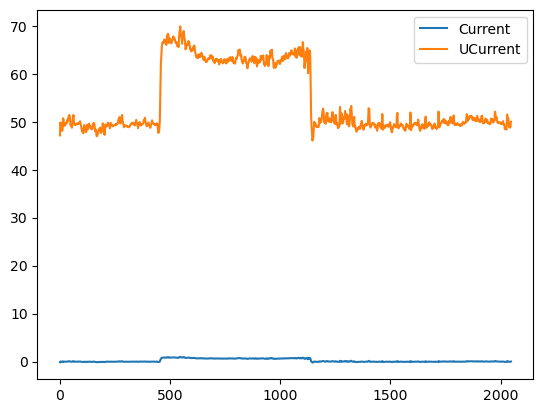

In [41]:
noise = tf.random.normal([BATCH_SIZE, WINDOW_SIZE])
generated_output = np.asarray(generator(noise, training = False))

current = generated_output[0,0,:,:]
print(current.shape)
plt.plot(current,label="Current")
tempx = generated_output[:,0,:,:].reshape(-1,1)
sgo=scaler.inverse_transform(tempx).reshape(100,-1)
#current= scaler.inverse_transform(current)
current = sgo[0,:]
print(current.shape)
plt.plot(current-0.2,label="UCurrent")


plt.legend()
plt.show()

## Various manipulations and outputs.
Create a specific output file without needing to train.
This cell does some monkey business now.  So assuming you have a live checkpoint and everything is running OK (you may have JUST restored a checkpoint).
This will run off and save a strip of data.
Then save the current model as a checkpoint in a different location to usual so we can then save it to GitHub. HOWEVER, it may be too large (>100MB) so it then zips the lot up into one archive... then splits this up so Git friendly.
There is then a routine at the bottom to remerge these mini archives into one proper zip archive which you can then restore.
In fact to do this there are a few steps.
Run filesplits merge facility...  create that zip archive.  copy paste and rename those files into your checkpoint location and naming format.
Then reload as per usual.  I have checked this works on another PC.


In [ ]:
from fsplit.filesplit import Filesplit
import shutil, os

epoch=0
x,y=[],[]
batches=2
for _ in range(batches):
    data=make_images(generator, epoch, gen_loss_list=[], disc_loss_list=[],plot=False)
    #Oops post processing defo needs cropping, since our CNNs focus on window centres
    #Added this now below...      
    np.save("data.npy", data)
    '''data = unscale_images(data.reshape(BATCH_SIZE,2,WINDOW_SIZE,1)).reshape((BATCH_SIZE,2,WINDOW_SIZE))'''
    for record in range(len(data[:,0,0])):
        cropped=data[record,0,:]
        cropped=cropped[CROP:-CROP]
        x.extend([pt for pt in cropped])
    for record in range(len(data[:,0,0])):
        cropped=data[record,1,:]
        cropped=cropped[CROP:-CROP]
        y.extend([pt for pt in cropped])
        
print('length of data strip is',len(x))
plt.subplot(2,2,1)
n, bins, patches =plt.hist(x,bins=100)
    
plt.subplot(2,2,2)
n, bins, patches =plt.hist(y,bins=100)
plt.vlines(-0.01,0,15000,"red")
plt.subplot(2,2,3)
plt.plot(x[:20000])
plt.subplot(2,2,4)
plt.plot(y[:20000])
#plt.xlim([0,0.4])

#plt.ylim([0,11000])
datadf = {'1cur':x,
        '2chan': y}
df = pd.DataFrame (datadf, columns = ['1cur','2chan'])
df.to_csv(f'{DATAFOLDER}/{WINDOW_SIZE}{DATAFOLDER}gen_data.csv', index =False, header=False)
print(np.mean(np.asarray(x)))
print(max(y))
print(y.count(2))
'''ALSO critically; write the current checkpoint to the folder too so reproducible'''
shutil.rmtree('checkpointsaved')
file_prefix= 'checkpointsaved/checkpointsaved_'
temploc='temp/chkpt.zip'
checkpoint.save(file_prefix = file_prefix)
'''zip it into one file'''
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))
      
zipf = zipfile.ZipFile(temploc, 'w', zipfile.ZIP_DEFLATED)
zipdir('checkpointsaved', zipf)
zipf.close()


'''but have to split it small or Git no cope'''
fs = Filesplit()
fs.split(file=temploc, split_size=50000000,output_dir=f'{DATAFOLDER}/chk')
print("sorted")

In [ ]:
start = time.time()
for epoch in range(10):  
    x=make_images(generator, epoch, gen_loss_list=[], disc_loss_list=[],plot=False)
    if epoch%1==0:
        # Console outputs
        clear_output(wait=True)
        print(f"Time for epoch {epoch} is {(time.time() - start)/BATCH_SIZE}s.")
        start = time.time()
        
np.save("numpy{DATAFOLDER}.NPY",x)

## If you wish to reload a previous checkpoint and retrain or just simulate
edit this cell.

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(generator, to_file='generator.png')
generator.summary()
plot_model(discriminator, to_file='discriminator.png')
discriminator.summary()

In [ ]:
'''When restoring use this to restore those checkpoint files'''
from fsplit.filesplit import Filesplit
fs = Filesplit()
fs.merge(input_dir=f'{DATAFOLDER}/chk')

In [ ]:
generator

In [ ]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
print(tf.__version__)
plot_model(
    discriminator, to_file='discriminator.png',dpi=300, show_shapes=True,
)
plot_model(
    generator, to_file='generator.png',dpi=300, show_shapes=True,
)